In [1]:
#Necessary Modules/Libraries
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as mo
import math

#For making pretty LaTeX plots
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 36,
    "axes.titlesize": 24,
    "axes.labelsize": 24,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 24,
    "figure.figsize": (8, 6),
    "figure.dpi": 100,
    "savefig.dpi": 200,
    "savefig.format": "png",
    "savefig.transparent": True,
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "grid.color": "0.8",
    "image.cmap": "Blues",
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
    "text.usetex": True, "mathtext.fontset": "cm",
    "pgf.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{cmbright}"
})

In [5]:
#Combining the datasets to have an overall view
train_df = pd.read_csv('../data/raw/training_set_VU_DM.csv')
test_df = pd.read_csv('../data/raw/test_set_VU_DM.csv')
all_data = pd.concat([train_df, test_df], ignore_index=True)

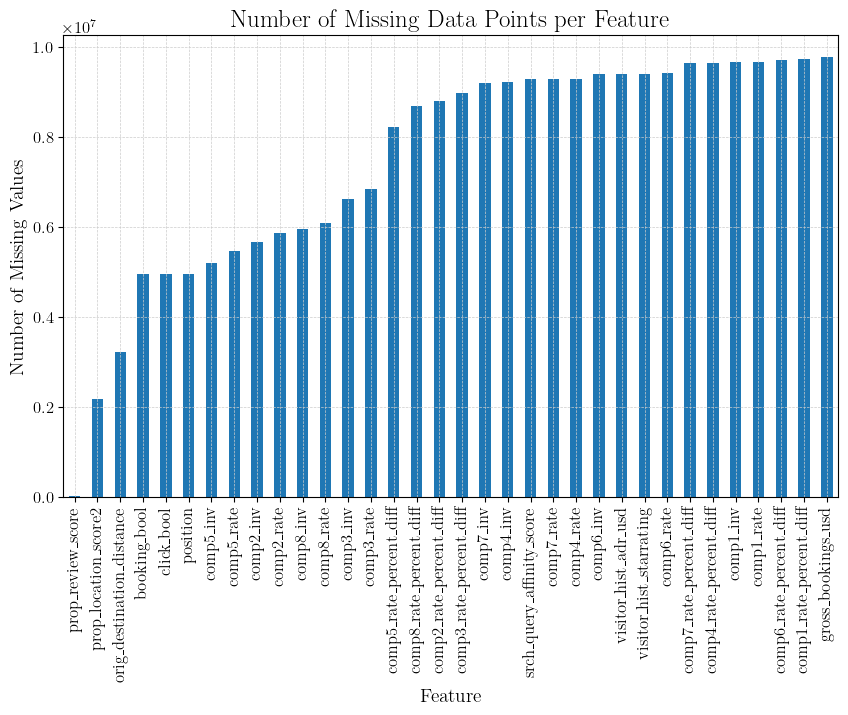

In [3]:
# Determining where the missing data is
missing = all_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
plt.figure(figsize=(10, 6))
missing.plot(kind='bar', title='Number of Missing Data Points per Feature')
plt.xlabel('Feature')
plt.ylabel('Number of Missing Values')
plt.show()

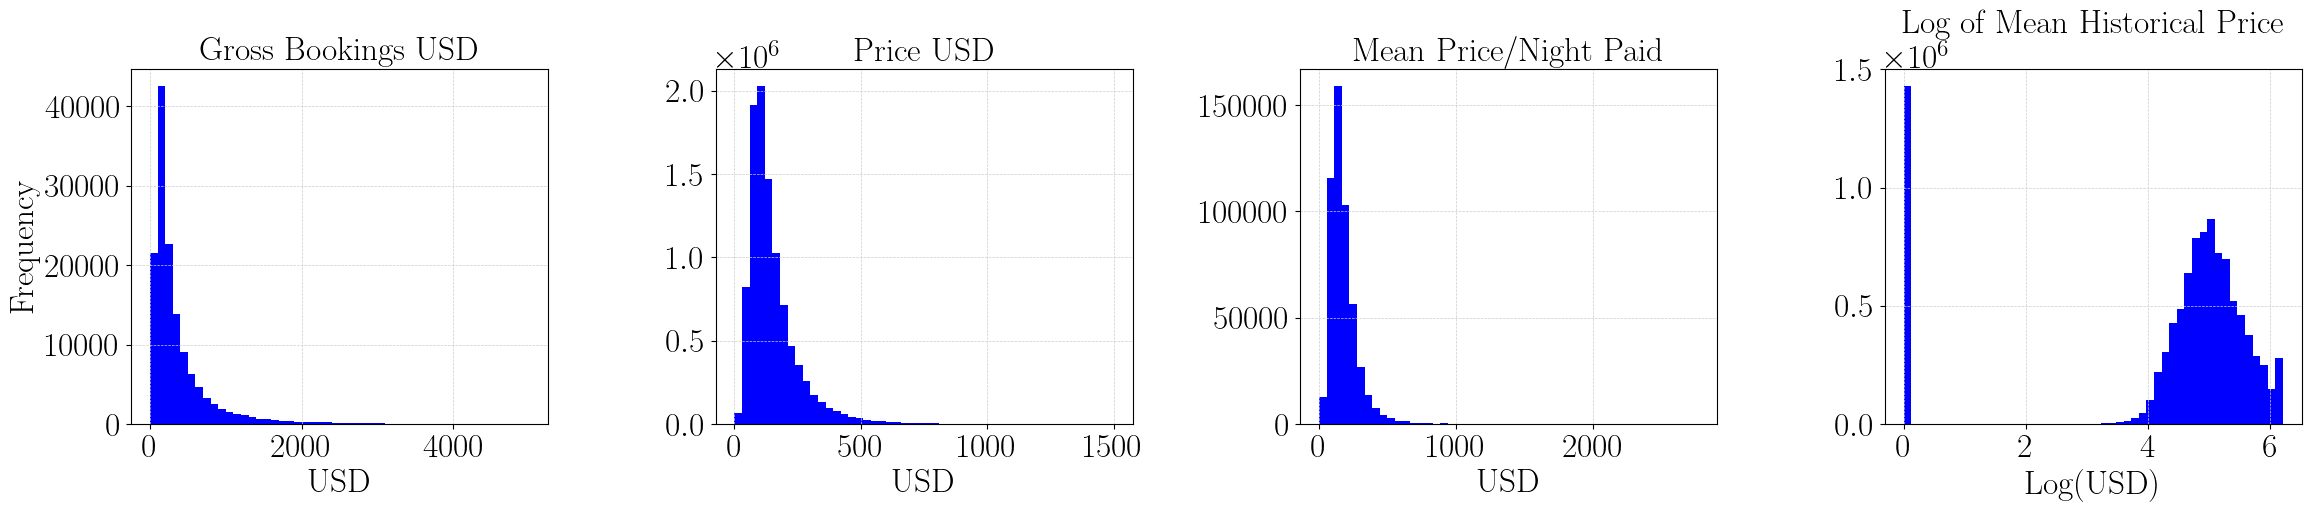

In [8]:
#Price Related Visualizations

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[0].hist(all_data['gross_bookings_usd'].dropna(), bins=50, range=(0,5000), color='blue')
axs[0].set_title("Gross Bookings USD")
axs[0].set_xlabel('USD')
axs[0].set_ylabel('Frequency')
axs[1].hist(all_data['price_usd'].dropna(), bins=50, range=(0,1500), color='blue')
axs[1].set_title("Price USD")
axs[1].set_xlabel('USD')
axs[2].hist(all_data['visitor_hist_adr_usd'].dropna(), bins=50, color='blue')
axs[2].set_title("Mean Price/Night Paid")
axs[2].set_xlabel('USD')
axs[3].hist(all_data['prop_log_historical_price'].dropna(), bins=50, color='blue')
axs[3].set_title("Log of Mean Historical Price")
axs[3].set_xlabel('Log(USD)')

plt.tight_layout()
plt.show()

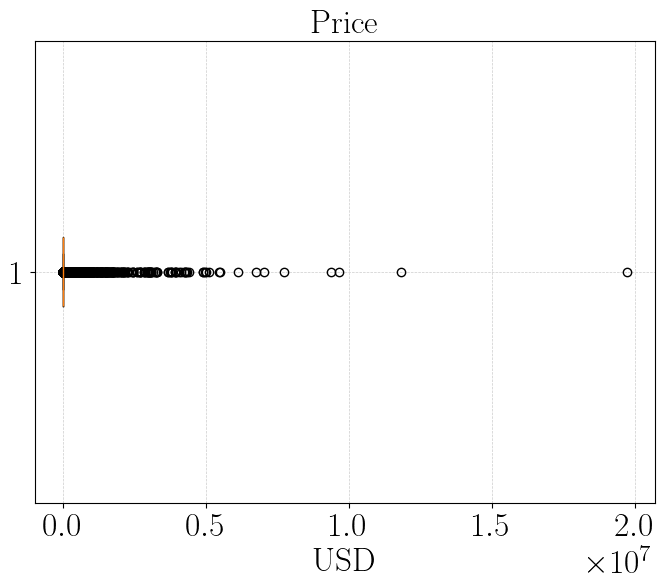

In [14]:
plt.figure(figsize=(8,6))
plt.boxplot(all_data['price_usd'].dropna(), vert=False)
plt.title("Price")
plt.xlabel("USD")
plt.ylabel("")
plt.show()


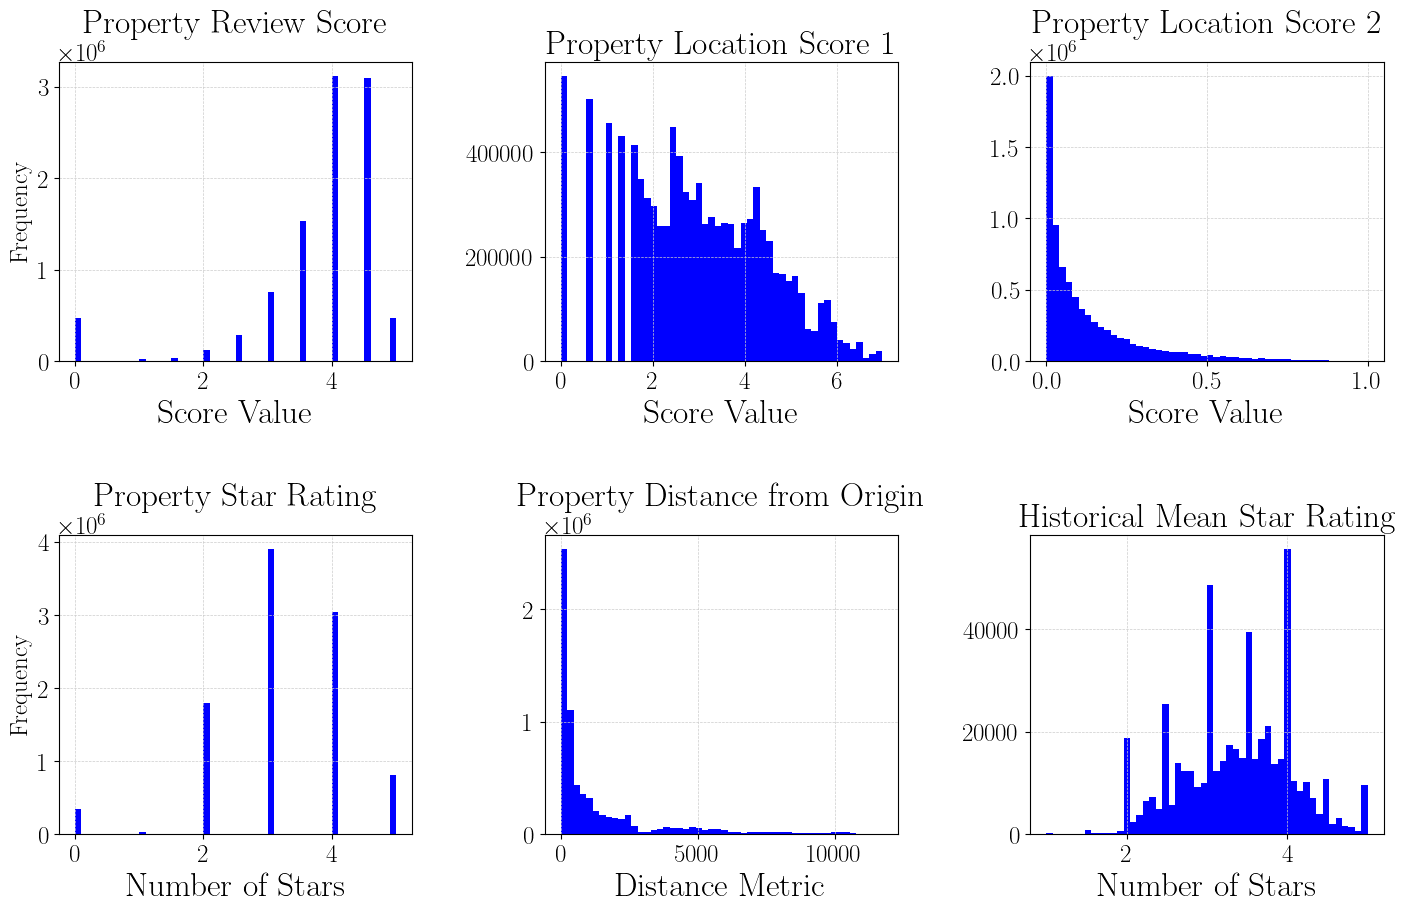

In [20]:
#Ratings and Property Related Visualizations

columns = ['prop_review_score', 'prop_location_score1', 'prop_location_score2', 'prop_starrating', 
           'orig_destination_distance', 'visitor_hist_starrating']
num_cols = 3  # Changed to 3
num_rows = math.ceil(len(columns) / num_cols) 
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
for i, feature in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].hist(all_data[feature].dropna(), bins=50, color='blue')
    
axs[0, 0].set_title('Property Review Score')
axs[0, 1].set_title('Property Location Score 1')
axs[0, 2].set_title('Property Location Score 2')  # Added
axs[1, 0].set_title('Property Star Rating')
axs[1, 1].set_title('Property Distance from Origin')
axs[1, 2].set_title('Historical Mean Star Rating')  # Added
axs[0, 0].set_xlabel('Score Value')
axs[0, 1].set_xlabel('Score Value')
axs[0, 2].set_xlabel('Score Value')  # Added
axs[1, 0].set_xlabel('Number of Stars')
axs[1, 1].set_xlabel('Distance Metric')
axs[1, 2].set_xlabel('Number of Stars')  # Added
axs[0, 0].set_ylabel('Frequency', fontsize=18)
axs[1, 0].set_ylabel('Frequency', fontsize=18)

plt.tight_layout()
plt.show()

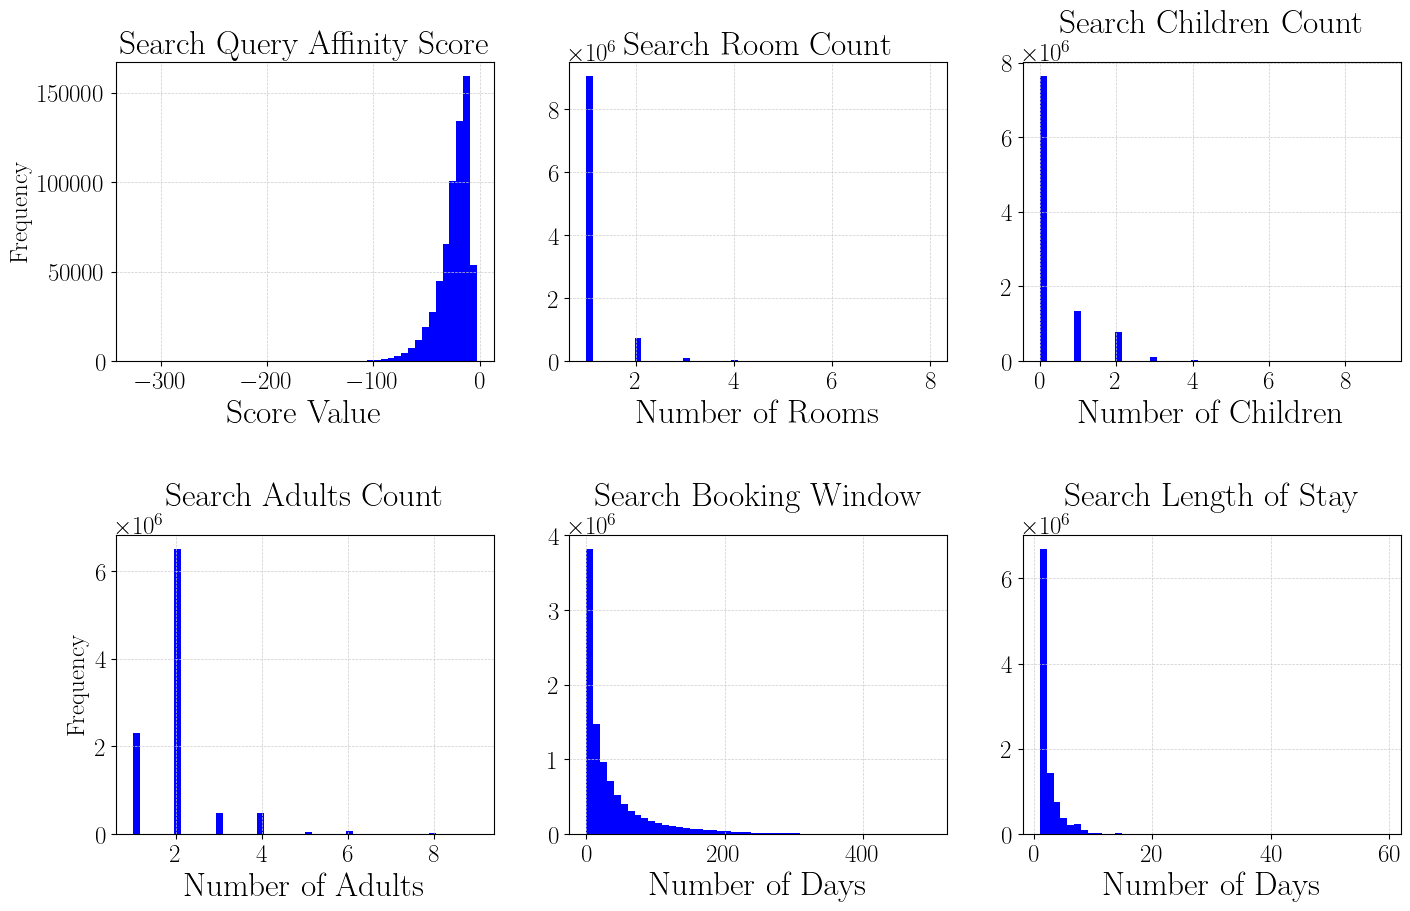

In [21]:
#Search Related Visualizations
columns = ['srch_query_affinity_score','srch_room_count', 'srch_children_count', 
           'srch_adults_count', 'srch_booking_window', 'srch_length_of_stay']
num_cols = 3  
num_rows = math.ceil(len(columns) / num_cols) 
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
for i, feature in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].hist(all_data[feature].dropna(), bins=50, color='blue')

axs[0, 0].set_title('Search Query Affinity Score')
axs[0, 1].set_title('Search Room Count')
axs[0, 2].set_title('Search Children Count')  
axs[1, 0].set_title('Search Adults Count')
axs[1, 1].set_title('Search Booking Window')
axs[1, 2].set_title('Search Length of Stay') 
axs[0, 0].set_xlabel('Score Value')
axs[0, 1].set_xlabel('Number of Rooms')
axs[0, 2].set_xlabel('Number of Children')  
axs[1, 0].set_xlabel('Number of Adults')
axs[1, 1].set_xlabel('Number of Days')
axs[1, 2].set_xlabel('Number of Days')  
axs[0, 0].set_ylabel('Frequency', fontsize=18)
axs[1, 0].set_ylabel('Frequency', fontsize=18)

plt.tight_layout()
plt.show()

A few things to note from the above distributions...
 - positions: this is an integer value for the rank of a certain hotel on the Expedia website. There will be missing values here because it's included in the training set but not the test set. I would probably fill with the average rank or according to some distribution.  

 - click_bool: this is also only found in the training set. I imagine, if it's null, we should just set it to 0.

 - visitor_hist_starrating: This is the mean star rating of hotels the customer has previously purchased and will be marked null if there is no purchase history on the customer. Maybe can fill with an "average" rating from that particular customer?

 - visitor_hist_adr_usd: The mean price per night (in US$) of the hotels the customer has previously purchased. This is the same issue of visitor_hist_starrating and maybe can be addressed the same way.

 - srch_query_affinity_score: The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative). A null signifies there are no data (i.e. hotel did not register in any searches). Honestly, we have over 130,000 hotels. Maybe if a hotel never shows up in any searches, we just remove it from the data entirely?

 - orig_destination_distance: Physical distance between the hotel and the customer at the time of search. A null means the distance could not be calculated. I'm not sure why the distance couldn't be calculated, nor do I think we want to try to do anything like that, but it definitely has some kind of distribution we could probably fill values with.
 
 - prop_location_score2: A (second) score outlining the desirability of the hotel’s location. I don't know how this is different from the first desirability score. Maybe we can avoid using this one and just use the first, or just fill in the values according to the distribution above. 

 - competitor data: see below

In [8]:
#Looking into hotels that are missing a lot of competitor data. We'll filter to hotels that have any competitor data.
all_prop_ids = all_data['prop_id'].unique()

features_to_check = ['comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff',
                     'comp2_rate', 'comp2_inv', 'comp2_rate_percent_diff',
                     'comp3_rate', 'comp3_inv', 'comp3_rate_percent_diff',
                     'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff',
                     'comp5_rate', 'comp5_inv', 'comp5_rate_percent_diff',
                     'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff',
                     'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff',
                     'comp8_rate', 'comp8_inv', 'comp8_rate_percent_diff']


filtered_data = all_data[all_data[features_to_check].isnull().all(axis=1)]
unique_prop_ids = filtered_data['prop_id'].unique()
prop_ids_not_null = list(set(all_prop_ids) - set(unique_prop_ids))

print("Unique hotel IDs where some the specified features are not null: ", prop_ids_not_null)
print('Number of hotels that have some competitor data: ', len(prop_ids_not_null))


Unique hotel IDs where some the specified features are not null:  [131073, 49156, 57349, 122889, 24586, 65547, 40972, 114699, 16398, 24590, 65552, 90126, 106510, 139285, 98326, 40985, 8218, 27, 16411, 57372, 65563, 122907, 131100, 139294, 40995, 32805, 49190, 139302, 98344, 131112, 32817, 41011, 90163, 16438, 49207, 16440, 57399, 122938, 24635, 41020, 8253, 49214, 122941, 16453, 49222, 65605, 98374, 114760, 131142, 24651, 49234, 139348, 90198, 16473, 106585, 16475, 82012, 106593, 32868, 16485, 49255, 24680, 82025, 114794, 139371, 16497, 114801, 131188, 82039, 98425, 41083, 16508, 123009, 65666, 16518, 82055, 8328, 65673, 82058, 106634, 131209, 57485, 24718, 32911, 98448, 65682, 73874, 82072, 153, 139417, 32924, 41117, 106659, 164, 131235, 106662, 24745, 41130, 32939, 49324, 73898, 32942, 123052, 139438, 139440, 57525, 182, 90293, 41147, 123071, 65728, 65730, 106690, 41156, 32974, 32976, 82131, 24791, 82135, 32987, 82139, 114910, 41185, 16615, 24808, 41194, 49386, 16621, 65774, 24817, 1

Text(0.5, 1.0, 'Missing Values')

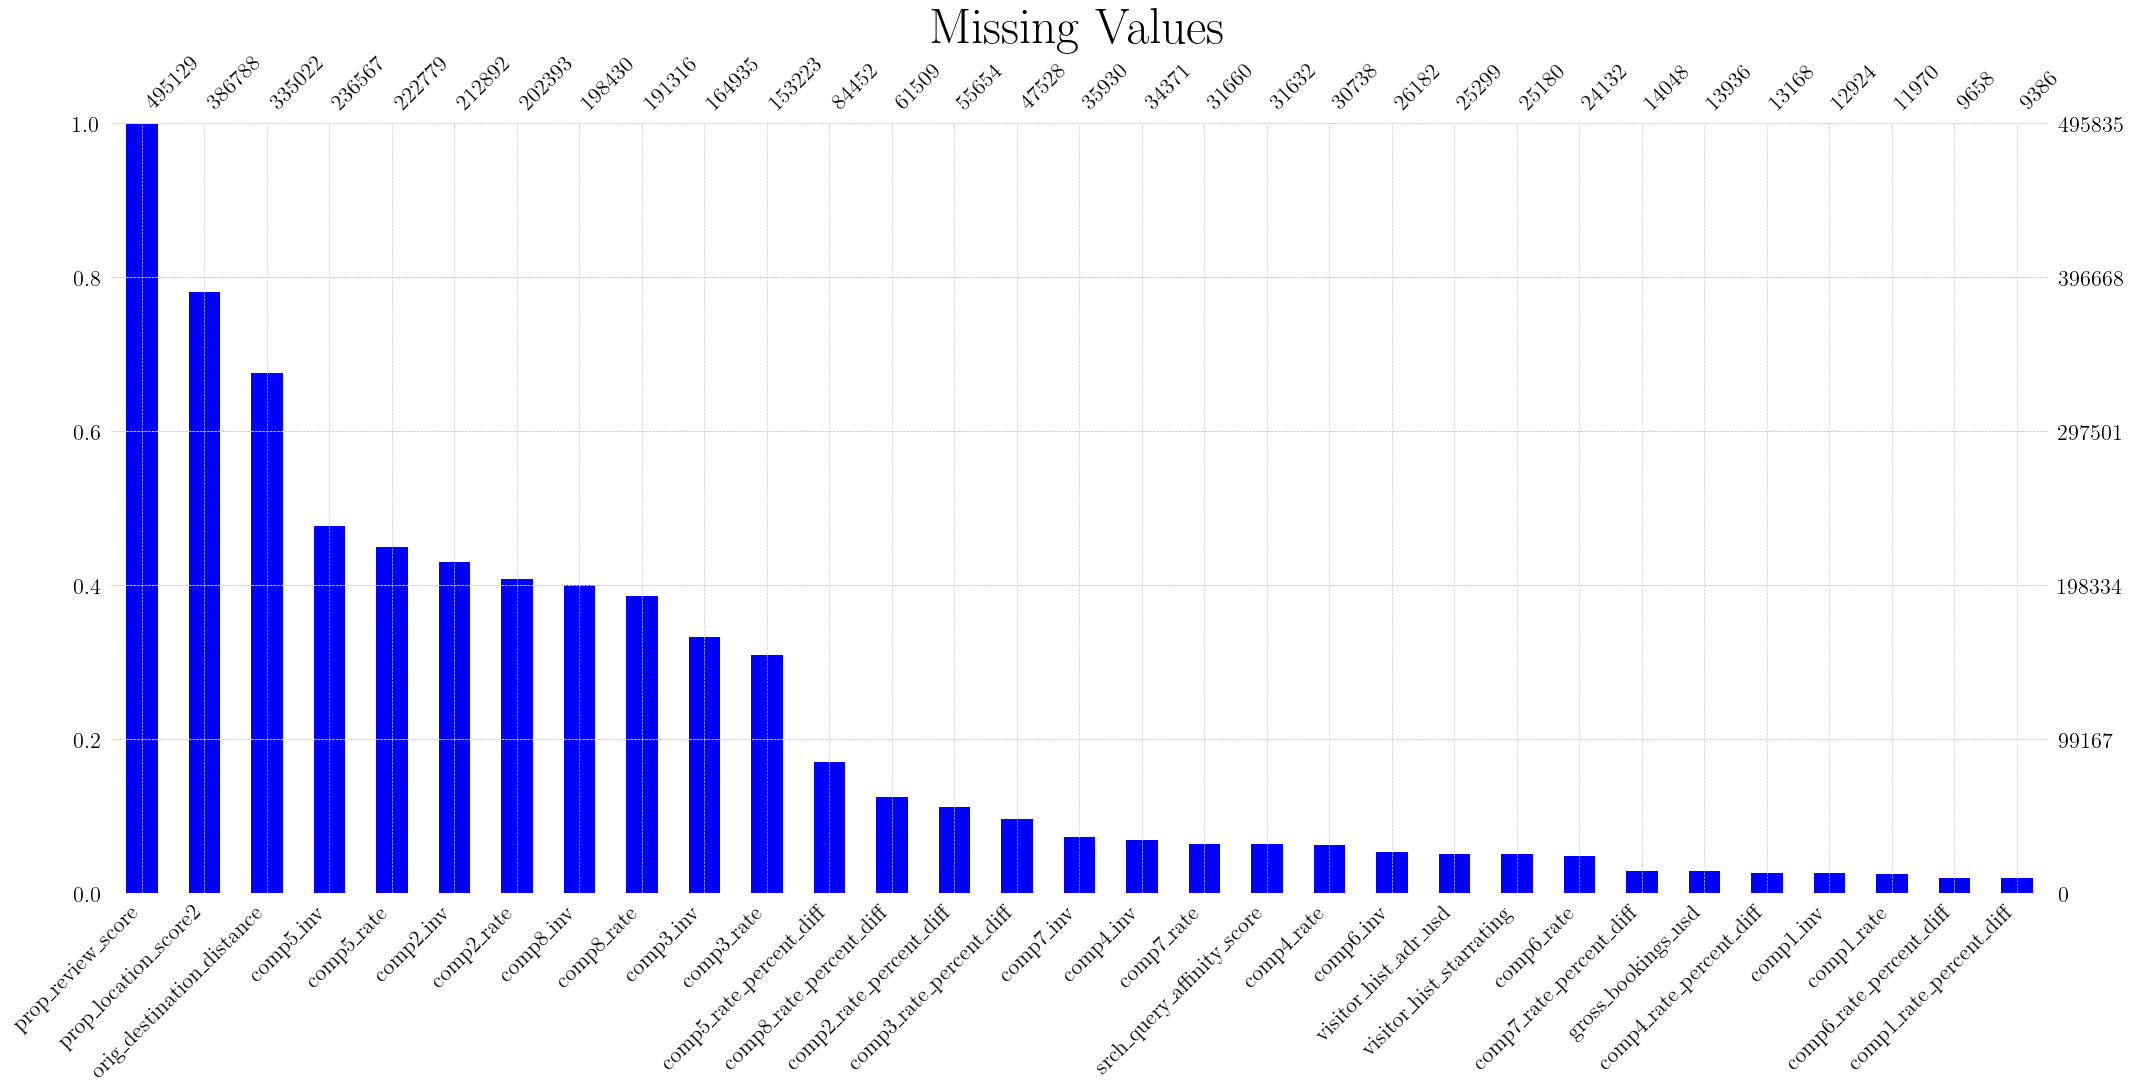

In [13]:
sampled_train = train_df.sample(frac=0.1)
sampled_test = test_df.sample(frac=0.1)
columns_with_missing_values = sampled_train.columns[sampled_train.isnull().any()]
mo.bar(sampled_train[columns_with_missing_values], sort='descending', color='blue') 
plt.title("Missing Values", fontsize=36)

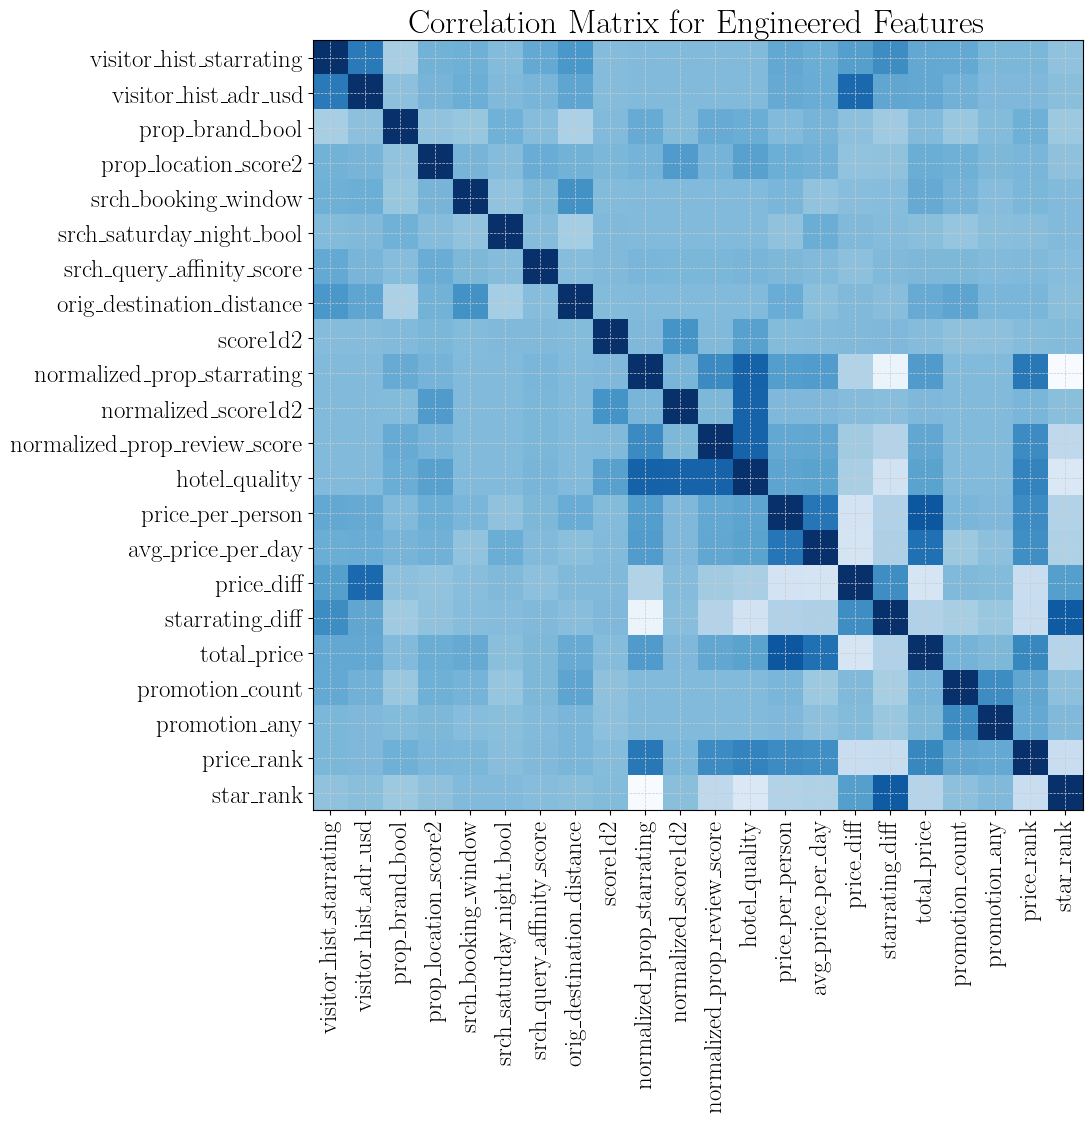

In [13]:
#Creating Correlation Plot for Engineered Data
engineered_data = pd.read_csv('../data/preprocessed/engineered_test_set.csv')

plt.figure(figsize=(12, 10))
columns_to_remove = ['date_time', 'ump', 'srch_id', 'site_id', 'prop_id', 'normalized_hotel_quality', 
                     'visitor_location_country_id', 'prop_country_id', 'srch_destination_id', 'random_bool', 
                     'has_hist_starrating', 'has_hist_adr_usd']
cleaned_data = engineered_data.drop(columns=columns_to_remove)
correlation_matrix = cleaned_data.corr()
plt.imshow(correlation_matrix, cmap='Blues', interpolation='nearest')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix for Engineered Features')
plt.show()